### Наша работа будет построена обучение на данных из FreiHAND Dataset. Данные взятые из открытого репозитория и доступны для скачивания любому желающему. 

### В изначальной версии в данных содержатся около 700к изображений, но только первые 32600 изображения размечены. Данные о разметки тоже хранятся в xyz пространстве, что для нас не совсем удобно. Используем данную информацию, проведем EDA данных и пересохраним данные в удобный для нас датафрейм для дальнейшего обучения

In [1]:
import os
import json
import random

import cv2
import pandas as pd
import numpy as np


from tqdm import tqdm
from matplotlib import pyplot as plt

In [2]:
# Cоздадим список изображений, которые есть у нас в дате

folder_path = '/kaggle/input/freihand-32000-first/FreiHAND_ppub_v2/FreiHAND_ppub_v2/img'
image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

In [3]:
image_files.sort()

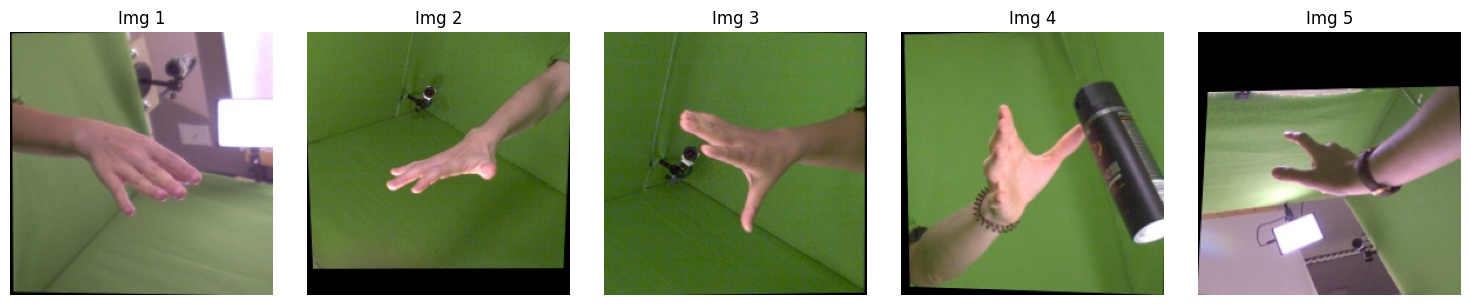

In [4]:
# Отобразим случайне изображения из данных 
random_images = random.sample(image_files, 5)
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
titles = ['Img {}'.format(i+1) for i in range(5)]
for i, (image_name, ax) in enumerate(zip(random_images, axes)):
    image_path = os.path.join(folder_path, image_name)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  
    ax.imshow(image)
    ax.set_title(titles[i])
    ax.axis('off')


plt.tight_layout()
plt.show()


In [5]:
# Возьмем функции для разметки якорных точек с официального репозитория 
def load_json_files():
    path_1 = "/kaggle/input/freihand-32000-first/FreiHAND_ppub_v2/FreiHAND_ppub_v2"
    path_2 = "/kaggle/input/freihand-32000-first"
    with open(f'{path_1}/training_K.json') as K_fp, open(f'{path_2}/training_verts.json') as verts_fp, open(f'{path_1}/training_xyz.json') as xyz_fp:
        K_array = json.load(K_fp)
        verts_array = json.load(verts_fp)
        xyz_array = json.load(xyz_fp)
        
        return K_array, verts_array, xyz_array
    
def projectPoints(xyz, K):
    """ Project 3D coordinates into image space. """
    xyz = np.array(xyz)
    K = np.array(K)
    uv = np.matmul(K, xyz.T).T
    return uv[:, :2] / uv[:, -1:]

def renderPose(img, uv):
    connections = [[0,1], [1,2], [2,3], [3,4], 
                   [0,5], [5,6], [6,7], [7,8], 
                   [0,9], [9,10],[10,11], [11,12],
                   [0,13],[13,14], [14,15], [15,16], 
                   [0,17],[17,18], [18,19], [19,20]]
    for c in connections:
        img = cv2.line(img,uv[c[0]],uv[c[1]],(255,0,0),2)
        
    for point in uv:
        img = cv2.circle(img, point, 2, (0,0,255), -1)
        
    return img

In [6]:
# Получим данные со значениями из данных, для создания дальнейшей разметки 
K_array, verts_array, xyz_array = load_json_files()

In [7]:
path_to_img_folder = "/kaggle/input/freihand-32000-first/FreiHAND_ppub_v2/FreiHAND_ppub_v2/img"

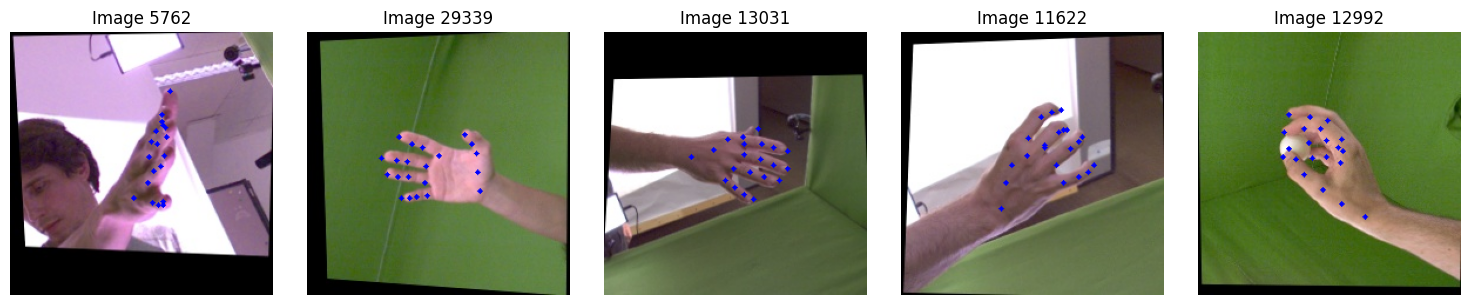

In [8]:
# Отобразим случайне изображения из данных c якорными точками 


fig, axes = plt.subplots(1, 5, figsize=(15, 3))
titles = []

for i, (ax) in enumerate(axes):
    index = random.randint(0,len(xyz_array))
    titles.append(f"Image {index}")
    path_to_img = os.path.join(path_to_img_folder, image_files[index])
    image = cv2.imread(path_to_img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    uv = projectPoints(xyz_array[index], K_array[index]).astype(np.int32)
    for point in uv:
        img = cv2.circle(image, point, 2, (0,0,255), -1)

    ax.imshow(img)
    ax.set_title(titles[i])
    ax.axis('off')


plt.tight_layout()
plt.show()

In [9]:
# Получается наша функция projectPoints(xyz_array[index], K_array[index]) возвращает коориднаты якорных точек в X Y пространстве. 
# Создадим данные в датафрейме для удобной работы при обучение данных. 

lst_path_to_img = []
lst_xy_point = []
for index in tqdm(range(len(xyz_array))):
    path_to_img = os.path.join(path_to_img_folder, image_files[index])
    
    image = cv2.imread(path_to_img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    uv = projectPoints(xyz_array[index], K_array[index]).astype(np.int32)
    
    lst_path_to_img.append(path_to_img)
    lst_xy_point.append(uv)

data = pd.DataFrame({"path_to_img": lst_path_to_img,
                     "xy_points": lst_xy_point,
                    })

100%|██████████| 32560/32560 [03:08<00:00, 173.07it/s]


In [10]:
data.head()

,path_to_img,xy_points
0,/kaggle/input/freihand-32000-first/FreiHAND_pp...,"[[131, 93], [115, 84], [105, 84], [94, 93], [7..."
1,/kaggle/input/freihand-32000-first/FreiHAND_pp...,"[[81, 99], [100, 102], [114, 96], [126, 91], [..."
2,/kaggle/input/freihand-32000-first/FreiHAND_pp...,"[[74, 141], [66, 144], [61, 147], [70, 153], [..."
3,/kaggle/input/freihand-32000-first/FreiHAND_pp...,"[[132, 145], [114, 137], [102, 132], [92, 125]..."
4,/kaggle/input/freihand-32000-first/FreiHAND_pp...,"[[102, 150], [121, 137], [135, 126], [139, 113..."


In [11]:
# Сохраним данные для дальнейшего использования и обучения 
data.to_csv('data_new.csv')